# Data Exploring

Data from: https://www.kaggle.com/datasets/felixzhao/productdemandforecasting

About Dataset


- Context

    The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.


- Content

    Historical Product Demand.csv - 
    CSV data file containing product demand for encoded product id's
    

- Acknowledgements

    This dataset is all real-life data and products/warehouse and category information encoded.


- Inspiration

    Is it possible to make forecasts for thousands of products (some of them are highly variable in terms of monthly demand) for the the month after next?


* Input file: Historical Product Demand.csv 


* Description: CSV data file containing product demand for encoded product id's


* Size of Data: (1048575, 5)


* Features: Product_Code, Warehouse, Product_Category, Date, Order_Demand


* Period: 2011-01-08 ~ 2017-01-09

In [1]:
# DataFrame
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# EEMD
from PyEMD.EEMD import EEMD

# Prophet 
#from prophet import Prophet
#from prophet.plot import plot_plotly, plot_components_plotly
#from prophet.plot import add_changepoints_to_plot

# Metric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

## 데이터 로드 및 확인

In [11]:
df = pd.read_csv('product_select.csv',encoding="CP949")
df

,Unnamed: 0,품번,품명,거래명세서일,출고수량,거래처명,product_class,code_length,product_type,customer,product_num,product,waste
0,1,2SWSKC0030,SK케미칼 SKYBON(청색)-3,2015-01-02,4000.0,에스케이케미칼,2,10,SW,SKC,0030,2SWSKC003,0
1,2,2SWHNH0040,한농화성 코펙스PEG4000(F)-4,2015-01-05,8000.0,한농화성,2,10,SW,HNH,0040,2SWHNH004,0
2,3,2LMSKG0080,SKGC CO-PP(중)-8,2015-01-06,70000.0,에스케이지오센트릭 주식회사,2,10,LM,SKG,0080,2LMSKG008,0
3,4,2LMSKG0020,SKGC PE-RT(MDPE) (대)-2,2015-01-07,70000.0,에스케이지오센트릭 주식회사,2,10,LM,SKG,0020,2LMSKG002,0
4,5,2LMSKG0080,SKGC CO-PP(중)-8,2015-01-08,70000.0,에스케이지오센트릭 주식회사,2,10,LM,SKG,0080,2LMSKG008,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42569,42570,2LMSKG0031,SKGC HDPE(YUZEX) (소)-3-1,2023-03-31,68876.0,에스케이지오센트릭 주식회사,2,10,LM,SKG,0031,2LMSKG003,0
42570,42571,2SWKHC0230,금호울산수지 HIPS-23,2023-03-31,16000.0,금호석유화학,2,10,SW,KHC,0230,2SWKHC023,0
42571,42572,2PEHWT0210,한화토탈에너지스(대산) HDPE연두롤백(AHR1) (PIR_샘플)-21,2023-03-31,330.0,한화토탈에너지스 주식회사,2,10,PE,HWT,0210,2PEHWT021,0
42572,42573,2SWHGN1780,한국내화 KOSACAST-70HF (25kg)영문-178,2023-03-31,3000.0,한국내화(충남),2,10,SW,HGN,1780,2SWHGN178,0


In [12]:
df['product'].describe()

count         42574
unique         2255
top       2SWKHC007
freq           1169
Name: product, dtype: object

In [13]:
# 데이터 확인
print('Size of Data:', df.shape)
print('')
for col in df.columns:
    print(f'{col}: {df[col].nunique()}')

Size of Data: (42574, 13)

Unnamed: 0: 42574
품번: 2396
품명: 2392
거래명세서일: 2372
출고수량: 5540
거래처명: 599
product_class: 2
code_length: 2
product_type: 14
customer: 457
product_num: 319
product: 2255
waste: 1


In [14]:
# 결측값 확인
df.isna().sum()

Unnamed: 0       0
품번               0
품명               0
거래명세서일           0
출고수량             0
거래처명             0
product_class    0
code_length      0
product_type     0
customer         0
product_num      0
product          0
waste            0
dtype: int64

In [15]:
# datetime dtype으로 변환
from datetime import datetime

df['거래명세서일'] = df['거래명세서일'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

### 하루에 팔린 양을 모두 SUM

    - 'Product_Code', 'Date', 'Warehouse', 'Product_Category' 가 겹치는 중복되는 행을 하나로 합함

In [16]:
df = df.groupby(['product', '거래명세서일', 'code_length', 'product_type'], as_index=False)['출고수량'].sum()
df

,product,거래명세서일,code_length,product_type,출고수량
0,1KOKHC001,2015-04-02,10,KO,18000.0
1,1KOKHC001,2015-04-28,10,KO,39000.0
2,1KOKHC001,2015-06-02,10,KO,39000.0
3,1KOKHC001,2015-07-10,10,KO,27000.0
4,1KOKHC001,2015-08-11,10,KO,27000.0
...,...,...,...,...,...
40274,2SWYSC008,2022-05-03,10,SW,13200.0
40275,2SWYSC008,2022-07-01,10,SW,13200.0
40276,2SWYSC008,2022-07-29,10,SW,13423.0
40277,2SWYSC008,2022-10-28,10,SW,13235.0


### Whse_J 공장으로 축소

## ADI-CV
### ADI-CV를 통해 1625개 제품 중 8개 선별

- Average Demand Interval (ADI): 주문 사이의 평균 시간 간격
- Coefficient of Variation (CV): 평균과 표준 편차의 비율로서 변동성

In [1]:
def ADI(df):
    ADI_lst = list()
    for prod in df['product'].unique():
        tmp_df = df.loc[df['product'] == prod].reset_index(drop=True)
        dvList = list()
        for i in range(len(tmp_df)):
            if i == 0:
                date = 0
                dvList.append(date) # first element's intervel is zero
            else:
                date = (tmp_df.loc[i]['거래명세서일'] - tmp_df.loc[i-1]['거래명세서일']).days # interval days
                dvList.append(date)
        tv = sum(dvList) / len(dvList)
        ADI_lst.append(tv)
        
    return ADI_lst

In [2]:
def CV(df):
    CV_lst = list()
    for prod in df['product'].unique():
        tmp_df = df.loc[df['product'] == prod].reset_index(drop=True)['출고수량']
        cv = np.std(tmp_df)/(np.mean(tmp_df)+0.001)
        CV_lst.append(cv)
    
    return CV_lst

In [19]:
def ADI_CV(df):
    ADI_lst = ADI(df)
    CV_lst = CV(df)
    # The standards of classification (Intermittent, Lumpy, Smooth, Erratic)

    ADI_CV_df= pd.DataFrame({'product' : df['product'].unique(),
                           'ADI' : ADI_lst,
                           'CV' : CV_lst,})
    return ADI_CV_df

def func(df) :
    if (df['ADI'] >= 0 ) & (df['ADI'] <= adi_median) & (df['CV'] >= 0 ) & (df['CV'] <= cv_median )  :
        return "Smooth"
    if (df['ADI'] > adi_median) & (df['CV'] > 0 ) & (df['CV'] < cv_median )  :
        return "Intermittent"
    if (df['ADI'] >= 0 ) & (df['ADI'] <= adi_median) & (df['CV'] >= cv_median )  :
        return "Lumpy"
    if (df['ADI'] > adi_median) & (df['CV'] > cv_median )  :
        return "Erratic"

#### ADI-CV 이후, 수요 패턴 분석

In [20]:
ADI_CV_df = ADI_CV(df)
adi_median = np.median(ADI_CV_df['ADI'])
cv_median = np.median(ADI_CV_df['CV'])
ADI_CV_df['Demand_pattern'] = ADI_CV_df.apply(lambda x : func(x), axis=1)

In [21]:
ADI_CV_df

,product,ADI,CV,Demand_pattern
0,1KOKHC001,54.301887,0.235391,Lumpy
1,1KOKHC005,53.872727,0.213088,Smooth
2,1KPWSC001,0.000000,0.000000,Smooth
3,1KPWSC002,0.000000,0.000000,Smooth
4,1KSADK001,117.055556,0.197941,Intermittent
...,...,...,...,...
2250,2SWYSA020,179.800000,0.465483,Erratic
2251,2SWYSC002,22.648352,0.099971,Smooth
2252,2SWYSC005,0.000000,0.000000,Smooth
2253,2SWYSC006,196.666667,0.100143,Intermittent


### 수요 데이터의 공백 확인

    - EX) 일주일 동안 팔린 기록이 하나라도 있었는지를 확인함.

In [22]:
def check_data(df):
    week_df = pd.DataFrame(columns=['product', 'Weeks'])
    start_date = df['거래명세서일'].min()
    end_date = df['거래명세서일'].max()
    
    products = df['product'].unique()
    continuous_lst = []
    
    for product in products:
        tmp_df = df[df['product'] == product].sort_values(by='거래명세서일')
        tmp_df['week'] = tmp_df['거래명세서일'].dt.to_period('W')
        
        # 데이터가 하나라도 존재하는 week이 개수
        unique_weeks = tmp_df['week'].nunique()
        week_tmp_df = pd.DataFrame({'product': [product], 'Weeks': [unique_weeks]})
        week_df = pd.concat([week_df, week_tmp_df])
    week_df.sort_values(by='Weeks', ascending=False, inplace=True)
    week_df.reset_index(drop=True, inplace=True)
    return week_df

In [23]:
start_date = df['거래명세서일'].min()
end_date = df['거래명세서일'].max()
print('데이터의 전체 Weeks: ', (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days // 7, '주')

데이터의 전체 Weeks:  430 주


In [24]:
# 제품을 Weeks수와 CV를 기준으로 상위 N개의 품목을 추려냄
def select_products(ADI_CV_df, week_df, Num): # @Num: 선별하고자 하는 제품 수
    tmp_df = pd.merge(ADI_CV_df, week_df, on='product')
    new_df.sort_values(['Weeks', 'CV'], ascending=[False, True], inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    products_lst = new_df['product'][:Num].tolist()
    
    return products_lst # a list of products

In [25]:
week_df = check_data(df)
week_df

,product,Weeks
0,2SWKHC007,397
1,2SWKHC003,396
2,2SWKHC005,387
3,2SWLGC019,342
4,2LMSIP002,325
...,...,...
2250,2PELGC018,1
2251,2LMCPB005,1
2252,2LMCJS001,1
2253,2LMBUM004,1


In [26]:
week_df.head(8)
#

,product,Weeks
0,2SWKHC007,397
1,2SWKHC003,396
2,2SWKHC005,387
3,2SWLGC019,342
4,2LMSIP002,325
5,2KVLTJ003,320
6,2KPKRI001,319
7,2SWSIP002,314


### 전체 날짜에 수요 분포가 있는 제품 확인

In [27]:
end_product = df[(df['거래명세서일']>'2017-01-01')]['product'].unique()
start_product = df[(df['거래명세서일']<'2017-01-10')]['product'].unique()
entire_product = set(end_product) & set(start_product)
entire_product = list(entire_product)

In [28]:
df.nunique()

product         2255
거래명세서일          2372
code_length        2
product_type      14
출고수량            5613
dtype: int64

### 제품의 카테고리 df 생성

In [29]:
categories = df['Product_Category'].unique()
category_map = {}

for category in categories:
    product_codes = df[df['Product_Category'] == category]['Product_Code'].unique()
    for product_code in product_codes:
        category_map[product_code] = category

cat_df = pd.DataFrame.from_dict(category_map, orient='index', columns=['Product_Category'])
cat_df.index.name = 'Product_Code'

KeyError: 'Product_Category'

In [31]:
#ADI_CV_df = ADI_CV_df[ADI_CV_df['Product_Code'].isin(entire_product)]
m_df = ADI_CV_df[(ADI_CV_df['ADI']<32.4) & (ADI_CV_df['CV']<0.59)].sort_values(by='CV')b
m_df = pd.merge(m_df, week_df, on='product')

SyntaxError: invalid syntax (2247576005.py, line 2)

### 최종 선별 품목 8개

In [204]:
product_lst = ['Product_1248',
               'Product_1295',
               'Product_0025',
               'Product_1378',
               'Product_2004',
               'Product_1154',
               'Product_0739',
               'Product_0901']

m_df[m_df['Product_Code'].isin(product_lst)]

,Product_Code,ADI,CV,Demand_pattern,Product_Category,Weeks
2,Product_1295,1.494659,0.641131,Smooth,Category_019,258
3,Product_1378,1.490581,0.665497,Smooth,Category_019,258
9,Product_2004,3.198944,0.748228,Smooth,Category_005,245
14,Product_1154,3.349353,0.775036,Smooth,Category_006,242
24,Product_0739,3.384328,0.886617,Smooth,Category_001,236
35,Product_0901,3.147059,0.979048,Smooth,Category_023,216
58,Product_0025,1.989119,1.083912,Smooth,Category_005,259
117,Product_1248,1.512053,1.300047,Lumpy,Category_019,259


In [205]:
df = df[df['Product_Code'].isin(product_lst)]
df.reset_index(drop=True)

,Product_Code,Date,Product_Category,Order_Demand
0,Product_0025,2012-01-05,Category_005,1600
1,Product_0025,2012-01-06,Category_005,1000
2,Product_0025,2012-01-10,Category_005,600
3,Product_0025,2012-01-11,Category_005,800
4,Product_0025,2012-01-12,Category_005,600
...,...,...,...,...
6778,Product_2004,2016-12-20,Category_005,6000
6779,Product_2004,2016-12-21,Category_005,7000
6780,Product_2004,2016-12-22,Category_005,1000
6781,Product_2004,2016-12-26,Category_005,2000


## 상위 15개 품목의 시계열 그래프 그리기

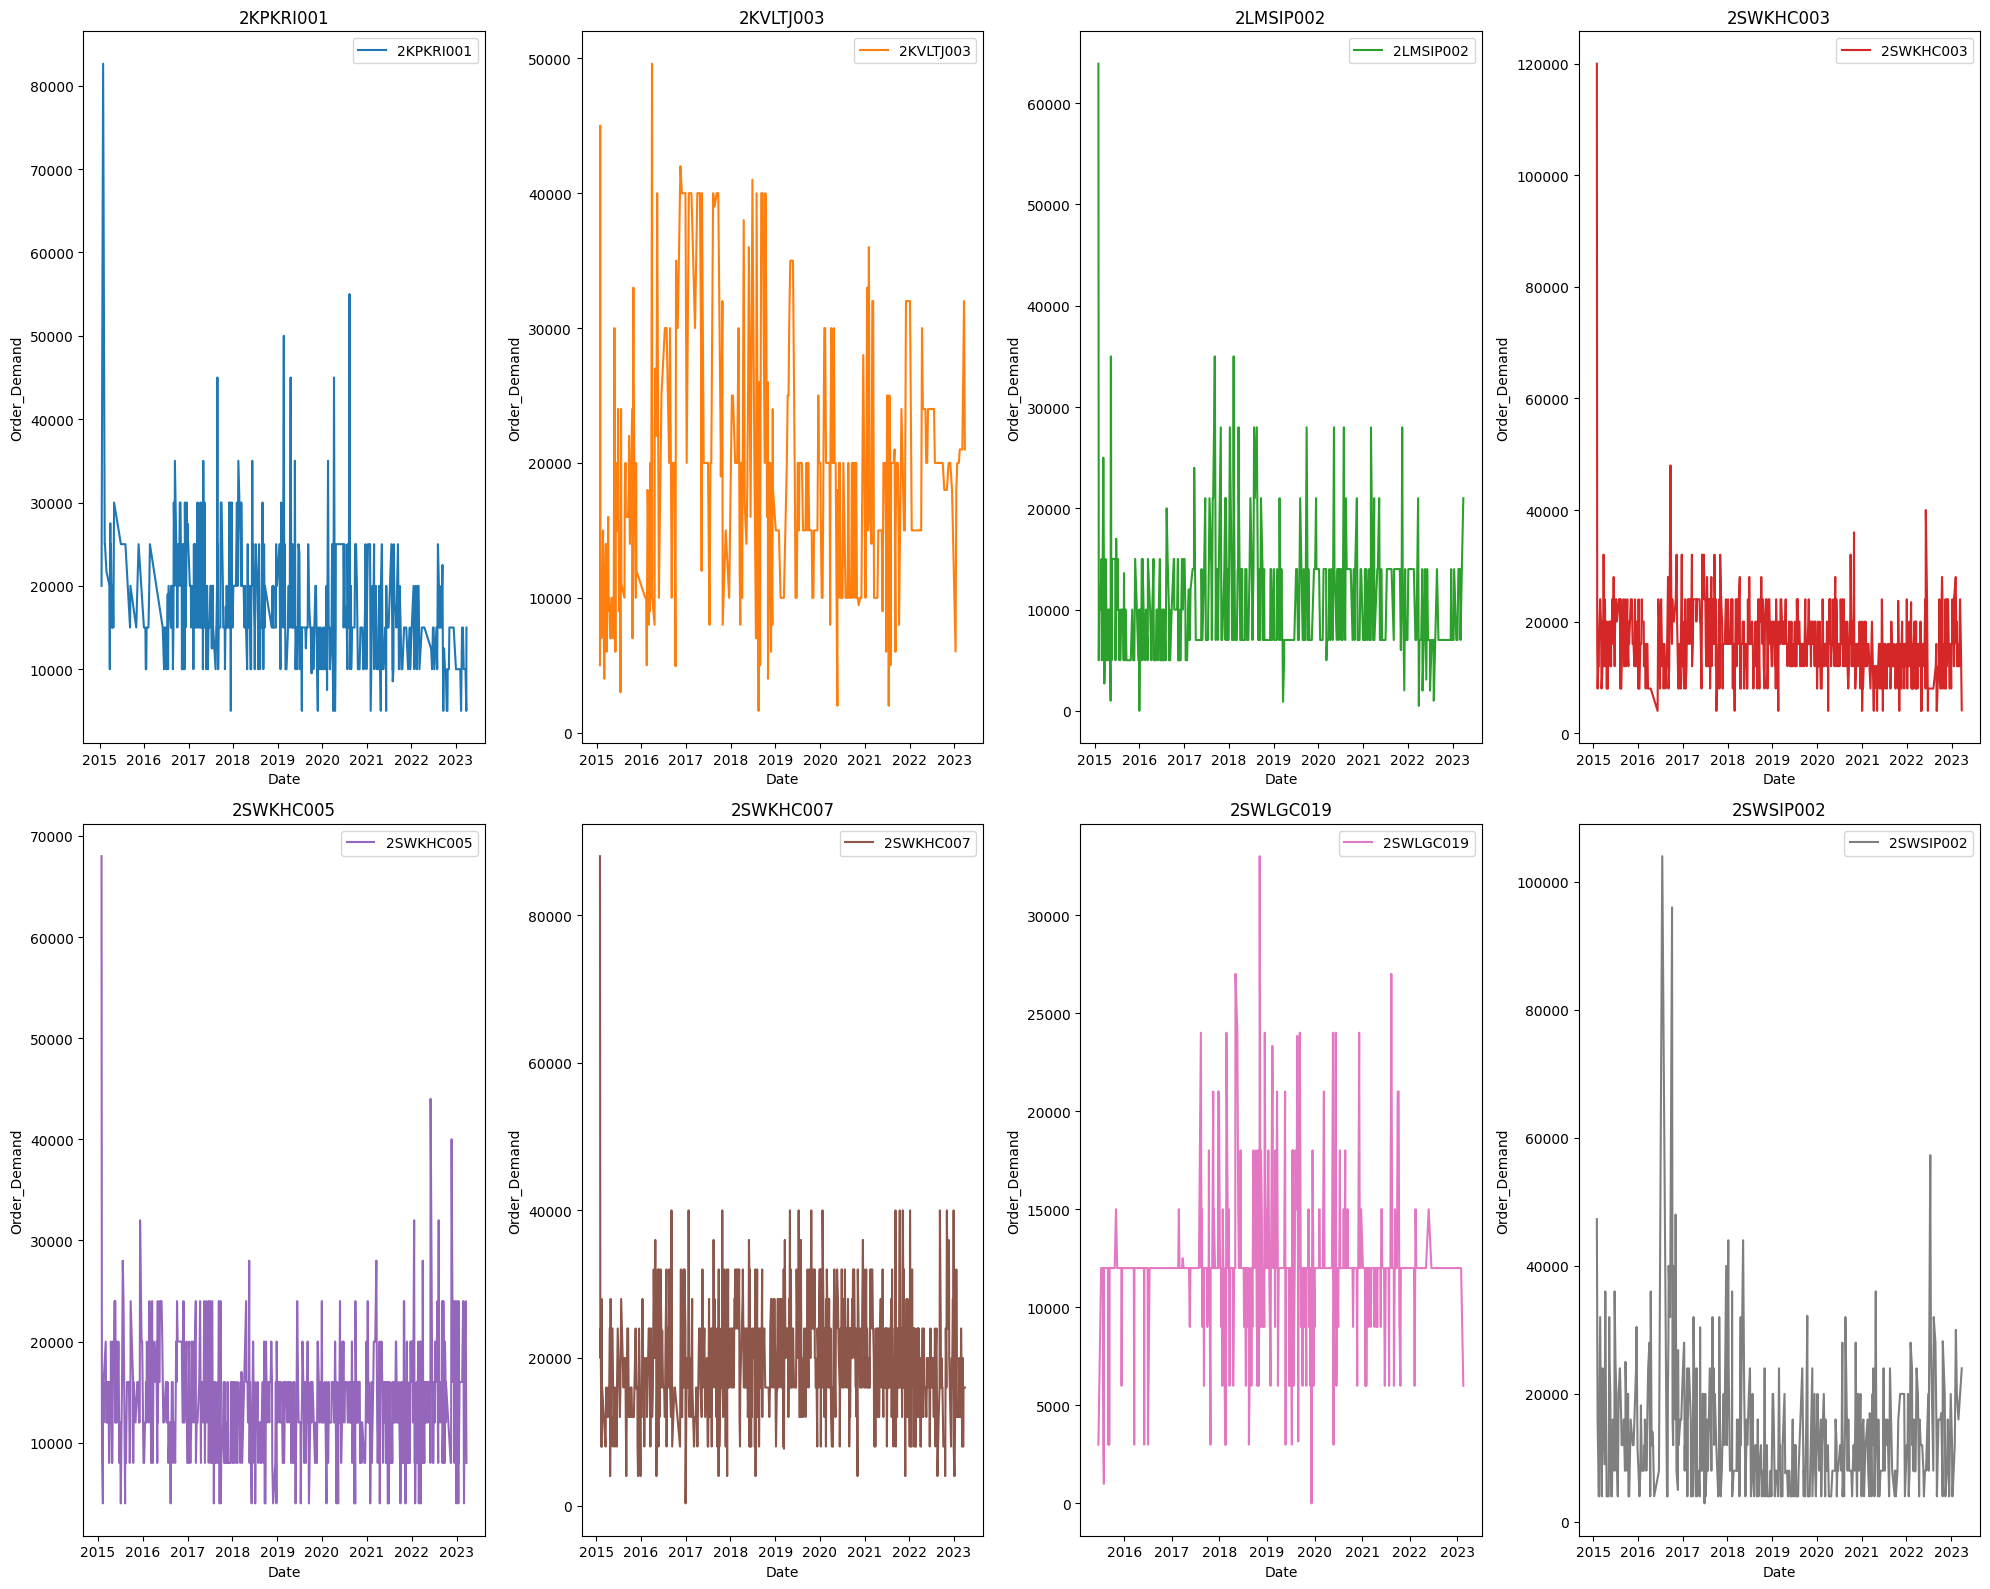

In [33]:
def plot_time(df):
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 16))
    
    for idx, code in enumerate(df['product'].unique()):
        row, col = idx // 4, idx % 4
        tmp_df = df[df['product'] == code][['거래명세서일', '출고수량']]
        axs[row, col].plot(tmp_df['거래명세서일'], tmp_df['출고수량'], label=code, color=f'C{idx}')
        axs[row, col].set_title(code)
        axs[row, col].set_xlabel('Date')
        axs[row, col].set_ylabel('Order_Demand')
        axs[row, col].legend()

    fig.tight_layout()
    plt.show()

# 상위 5개 품목의 시계열 그래프 그리기
product_lst = ['2SWSIP002',
               '2SWKHC007',
               '2SWKHC003',
               '2SWKHC005',
               '2SWLGC019',
               '2LMSIP002',
               '2KPKRI001',
               '2KVLTJ003']


df_selection = df[df['product'].isin(product_lst)]
df_selection.reset_index(drop=True)
plot_time(df_selection)

### 판매가 없는 Date의 Order_Demand를 0으로 채움

In [34]:
def fill_zero(df):
    new_df = pd.DataFrame()
    for i,code in enumerate(df['product'].unique()):
        #print(f'{i}/{df['Product_Code'].nunique()}')
        category = df[df['product']==code]['product_type'].unique()[0]
        tmp_df = df.groupby('product').get_group(code)
        
        start_date = tmp_df['거래명세서일'].min()
        end_date = tmp_df['거래명세서일'].max()
        # full range of Date
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        date_df = pd.DataFrame(date_range, columns=['거래명세서일'])
        # 기존 데이터와 새로운 DataFrame을 병합하고 Order_Demand를 0으로 채웁니다.
        merged_df = pd.merge(date_df, tmp_df, on='거래명세서일', how='left')
        merged_df['출고수량'].fillna(0, inplace=True)
        merged_df['product'].fillna(code, inplace=True)
        merged_df['product_type'].fillna(category, inplace=True)
        #merged_df['Warehouse'].fillna(method='ffill', inplace=True)
        
        new_df = pd.concat([new_df, merged_df], axis=0, ignore_index=True)

    return new_df

In [39]:
df_selection[df_selection['product']=='2SWKHC007']

,거래명세서일,product,code_length,product_type,출고수량
14906,2015-01-31,2SWKHC007,10.0,SW,88000.0
14907,2015-02-01,2SWKHC007,NaN,SW,0.0
14908,2015-02-02,2SWKHC007,NaN,SW,0.0
14909,2015-02-03,2SWKHC007,10.0,SW,20000.0
14910,2015-02-04,2SWKHC007,NaN,SW,0.0
...,...,...,...,...,...
17883,2023-03-27,2SWKHC007,NaN,SW,0.0
17884,2023-03-28,2SWKHC007,NaN,SW,0.0
17885,2023-03-29,2SWKHC007,NaN,SW,0.0
17886,2023-03-30,2SWKHC007,NaN,SW,0.0


### 수요가 없는 날을 0으로 채움

In [37]:
df_selection = fill_zero(df_selection)
df_selection

,거래명세서일,product,code_length,product_type,출고수량
0,2015-01-17,2KPKRI001,10.0,KP,20000.0
1,2015-01-18,2KPKRI001,NaN,KP,0.0
2,2015-01-19,2KPKRI001,NaN,KP,0.0
3,2015-01-20,2KPKRI001,NaN,KP,0.0
4,2015-01-21,2KPKRI001,NaN,KP,0.0
...,...,...,...,...,...
23667,2023-03-25,2SWSIP002,NaN,SW,0.0
23668,2023-03-26,2SWSIP002,NaN,SW,0.0
23669,2023-03-27,2SWSIP002,NaN,SW,0.0
23670,2023-03-28,2SWSIP002,NaN,SW,0.0


In [38]:
# 파일 저장
df_selection.to_csv('PNS_0501.csv', index=False)